## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Import Data

In [75]:
mta_df = pd.read_csv("./Turnstile_Usage_Data__2017.csv")

## Convert to Datetime Object

In [93]:
mta_df['Datetime'] = pd.to_datetime(mta_df['Date'] + mta_df['Time'], 
                                  format='%m/%d/%Y%H:%M:%S')

## Select timeframe (if applicable)

In [77]:
start_date = '20170114'
end_date = '20170221'
mta_df = mta_df[(mta_df['Datetime'] > start_date) & (mta_df['Datetime'] < end_date) ]

In [ ]:
#mta_df[(mta_df['Station'] == top20_station[0]) & (mta_df['Date'] == '01/22/2017')]

## Add a column of day_of_week and a column of holiday

In [78]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

mta_df['Day'] = mta_df['Datetime'].dt.dayofweek

cal = calendar()
holidays = cal.holidays(start=mta_df.Date.min(), end=mta_df.Date.max())

mta_df['Holiday'] = mta_df['Date'].isin(holidays)

## Calculate Entries in Each Time Interval

In [79]:
# sort records by C/A, Unit, SCP, and Station for calculation
mta_df = mta_df.sort_values(['C/A', 'Unit', 'SCP', 'Station','Datetime'])

# create columns of C/A, Unit, SCP, and Station with one row shift down
mta_df['Entries_shifted'] = mta_df['Entries'].shift(1)
mta_df['C/A_shifted'] = mta_df['C/A'].shift(1)
mta_df['Unit_shifted'] = mta_df['Unit'].shift(1)
mta_df['SCP_shifted'] = mta_df['SCP'].shift(1)
mta_df['Station_shifted'] = mta_df['Station'].shift(1)
mta_df['Previous_Datetime'] = mta_df['Datetime'].shift(1)

# only calcuate the entries difference if C/A, Unit, SCP, and Station are same
cond = (mta_df['C/A_shifted'] == mta_df['C/A'])\
        &(mta_df['Unit_shifted'] == mta_df['Unit'])\
        &(mta_df['SCP_shifted'] == mta_df['SCP'])\
        &(mta_df['Station_shifted'] == mta_df['Station'])

mta_df['Entries_4_hours'] = mta_df['Entries'] - mta_df['Entries_shifted'] 
mta_df['Entries_4_hours_cleaned'] = np.where(cond, mta_df['Entries_4_hours'], 0)

In [59]:
mta_df_top20 = mta_df[(mta_df['Station'] == top20_station[0])]

In [74]:
#mta_df_top20[mta_df_top20['Description'] == 'REGULAR']['Time'].unique()
#mta_df_top20[(mta_df_top20['Description'] == 'REGULAR') & (mta_df_top20['Time'] == '20:53:38')]
mta_df.head()

,C/A,Unit,SCP,Station,Line Name,Division,Date,Time,Description,Entries,Exits,Datetime,Day,Holiday,Previous_Datetime,Entries_4_hours,Entries_4_hours_cleaned
389002,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/14/2017,07:00:00,REGULAR,6009253,2035115,2017-01-14 07:00:00,5,False,2017-01-14 03:00:00,12.0,12.0
389003,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/14/2017,11:00:00,REGULAR,6009313,2035217,2017-01-14 11:00:00,5,False,2017-01-14 07:00:00,60.0,60.0
389004,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/14/2017,15:00:00,REGULAR,6009492,2035273,2017-01-14 15:00:00,5,False,2017-01-14 11:00:00,179.0,179.0
389005,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/14/2017,19:00:00,REGULAR,6009814,2035351,2017-01-14 19:00:00,5,False,2017-01-14 15:00:00,322.0,322.0
389006,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/14/2017,23:00:00,REGULAR,6009995,2035371,2017-01-14 23:00:00,5,False,2017-01-14 19:00:00,181.0,181.0


In [80]:
# drop shifted columns

mta_df = mta_df.drop(['C/A_shifted', 'Unit_shifted', 'SCP_shifted', 'Station_shifted', 'Entries_shifted'], axis=1)

### There are still rows with negative entries number, need to decide what to do with them

In [83]:
# drop record with negative entries every 4 hours
mta_df = mta_df[mta_df['Entries_4_hours_cleaned'] > 0]

## Total number of turnstile

In [84]:
mta_df.groupby(['C/A','Unit', 'SCP', 'Station'])['Entries_4_hours_cleaned'].sum().count()

4364

## total number of station

In [85]:
mta_df.groupby(['Station'])['Entries_4_hours_cleaned'].sum().count()

374

## Statistic Summary of Cleaned Entries Every 4 Hours

In [86]:
# explore entries distribution
mta_df['Entries_4_hours_cleaned'].describe()

count    7.222170e+05
mean     9.766397e+03
std      3.519341e+06
min      1.000000e+00
25%      3.000000e+01
50%      1.080000e+02
75%      2.760000e+02
max      2.122193e+09
Name: Entries_4_hours_cleaned, dtype: float64

## distribution of entries in every 4 hours at a turnstile

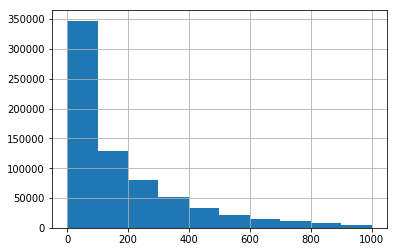

In [87]:
mta_df['Entries_4_hours_cleaned'].hist(range=[0, 1e3])

## distribution of daily entries at a turnstile

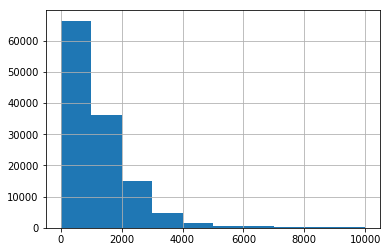

In [88]:
#mta_df.groupby(['C/A','Unit', 'SCP', 'Station', 'Date'])['Entries_4_hours_cleaned'].sum()
mta_df.groupby(['C/A','Unit', 'SCP', 'Station','Date'])['Entries_4_hours_cleaned'].sum().hist(range=[0, 1e4])

## distribution of daily entries at a station

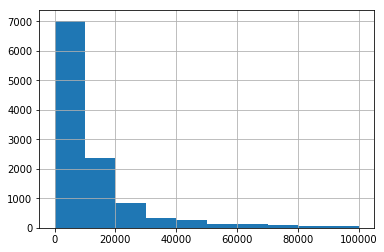

In [89]:
mta_df.groupby(['Station','Date'])['Entries_4_hours_cleaned'].sum().hist(range=[0, 1e5])

## distribution of sum of entries on a day of the week at a station

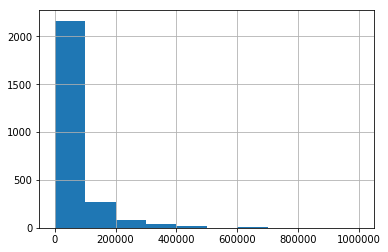

In [90]:
#mta_df.groupby(['Station', 'day'], as_index=False)['Entries_4_hours_cleaned'].sum()

mta_df.groupby(['Station', 'Day'])['Entries_4_hours_cleaned'].sum().hist(range=[0,1e6])

In [91]:
top20_station = (list(mta_df.groupby(['Station'])['Entries_4_hours_cleaned']
                      .sum().sort_values(ascending=False).head(20).index)
                )
top20_station

['14 ST',
 '34 ST-HERALD SQ',
 'CHAMBERS ST',
 '231 ST',
 'HIGH ST',
 'METROPOLITAN AV',
 'CLINTON-WASH AV',
 '5 AVE',
 '15 ST-PROSPECT',
 'UTICA AV',
 '34 ST-PENN STA',
 'GRD CNTRL-42 ST',
 '23 ST',
 '14 ST-UNION SQ',
 'TIMES SQ-42 ST',
 '42 ST-PORT AUTH',
 '86 ST',
 'FULTON ST',
 '125 ST',
 '59 ST COLUMBUS']

In [92]:
mta_df[mta_df['Station'] == top20_station[0]].groupby(['Date'])['Entries_4_hours_cleaned'].sum()

Date
01/14/2017    2.879700e+04
01/15/2017    2.893900e+04
01/16/2017    3.531500e+04
01/17/2017    5.812500e+04
01/18/2017    6.037800e+04
01/19/2017    6.197500e+04
01/20/2017    6.053100e+04
01/21/2017    3.297700e+04
01/22/2017    2.122217e+09
01/23/2017    5.139800e+04
01/24/2017    5.652800e+04
01/25/2017    6.079400e+04
01/26/2017    6.072600e+04
01/27/2017    5.992300e+04
01/28/2017    3.665800e+04
01/29/2017    2.919800e+04
01/30/2017    5.434500e+04
01/31/2017    5.913900e+04
02/01/2017    6.165900e+04
02/02/2017    6.244900e+04
02/03/2017    5.932200e+04
02/11/2017    3.673220e+05
02/12/2017    2.539600e+04
02/13/2017    5.733500e+04
02/14/2017    6.216700e+04
02/15/2017    6.200800e+04
02/16/2017    6.109700e+04
02/17/2017    5.829600e+04
02/18/2017    3.203200e+04
02/19/2017    2.792800e+04
02/20/2017    3.003500e+04
Name: Entries_4_hours_cleaned, dtype: float64